# Tomographic indexing notebook with minor phase adjustments  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This notebook is optimised for a weaker minor phase in a larger major phase sample.  
This means your peaks have been merged across omega and dty.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# phase names
major_phase_strs = ['Fe']
minor_phase_str = 'Au'

# peak filtration parameters
min_frames_per_peak = 0
# whether to filter out major phase peaks before trying to index
remove_major_phase_peaks = True
major_phase_cf_dstol = 0.005
minor_phase_cf_frac = 0.9975
minor_phase_cf_dsmax = 1.594
minor_phase_cf_dstol = 0.005

# indexing
rings_for_gen = [0, 4, 5]

# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]

# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

peak_assign_tol = 0.025

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
major_phase_strs = ["Fe"]
minor_phase_str = "Au"
remove_major_phase_peaks = True
min_frames_per_peak = 0
major_phase_cf_dstol = 0.0035
minor_phase_cf_frac = 0.9
minor_phase_cf_dsmax = 1.594
minor_phase_cf_dstol = 0.0045
rings_for_gen = [0, 4, 5]
rings_for_scoring = [0, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05]
fracs = [0.9, 0.7]
max_grains = 1000
peak_assign_tol = 0.05
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [4]:
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.nbGui.nb_utils as utils
from ImageD11.peakselect import select_ring_peaks_by_intensity, remove_peaks_from_phases

%matplotlib ipympl

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

Now we need to decide which are our 'major' phases, which we will remove from our peaks before indexing.

In [7]:
major_phase_unitcells = [ds.phases.unitcells[mps] for mps in major_phase_strs]
print(*major_phase_unitcells)
minor_phase_unitcell = ds.phases.unitcells[minor_phase_str]
print(minor_phase_unitcell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229
Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


## Peaks

In [8]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)  # computes geometry, needed for filtration
for major_phase_unitcell in major_phase_unitcells:
    major_phase_unitcell.makerings(cf_4d.ds.max())
minor_phase_unitcell.makerings(cf_4d.ds.max())

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


In [9]:
# Optionally remove some noisy peaks
if min_frames_per_peak > 0:
    cf_4d.filter(cf_4d['npk2d'] > min_frames_per_peak)

# Filtration
## (optional) remove major phase peaks

In [10]:
if remove_major_phase_peaks:
    cf_4d = remove_peaks_from_phases(cf_4d, major_phase_cf_dstol, major_phase_unitcells)

## Filter by intensity
Now we are filtering our peaks (`cf_4d`) to select only the strongest ones for indexing purposes only!  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`dsmax`: The maximum allowed peak $d^{*}$ value. Used to limit the number of rings given to the indexer - 6-8 rings max are normally sufficient.   
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

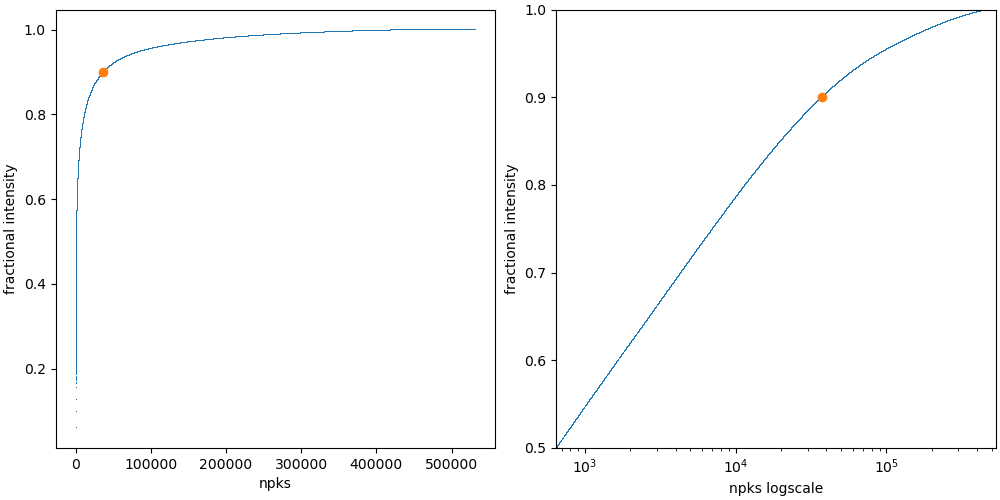

Filtered 37132 peaks from 1565669


In [11]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=minor_phase_cf_frac, dsmax=minor_phase_cf_dsmax, dstol=minor_phase_cf_dstol, ucell=minor_phase_unitcell, doplot=0.5)

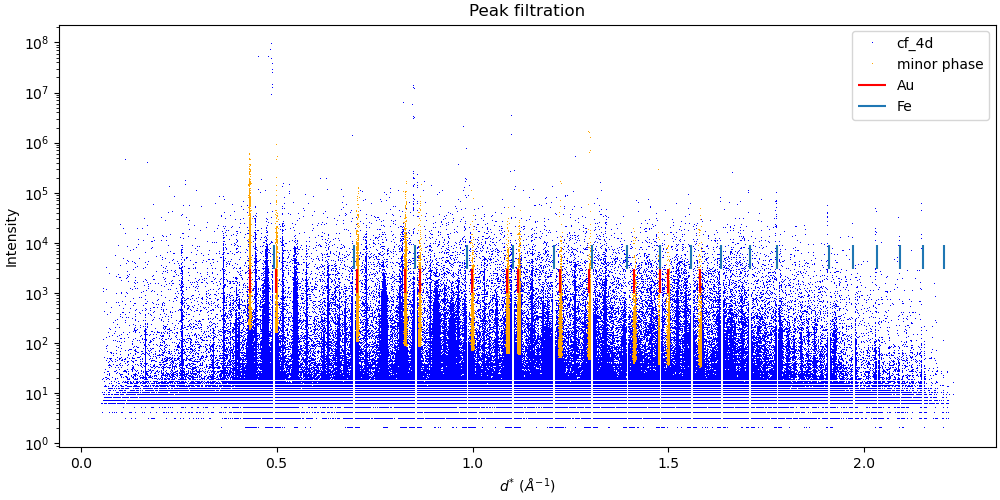

In [12]:
minor_phase_unitcell.makerings(cf_strong.ds.max())
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d',c='blue')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='minor phase',c='orange')
ax.vlines(minor_phase_unitcell.ringds, 1e3, 3e3, color='red', label=minor_phase_unitcell.name)
for inc, major_phase_unitcell in enumerate(major_phase_unitcells):
    ax.vlines(major_phase_unitcell.ringds, 3e3*(3**inc), 3e3*(2**inc)*3, color=plt.color_sequences['tab20'][inc], label=major_phase_unitcell.name)
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment

In [13]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, minor_phase_unitcell)
indexer.ds_tol = minor_phase_cf_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.02718425  0.4144168  -0.27254829]
 [-0.01697573  0.32459122 -0.28053982]
 [-0.14538085 -0.84145176  0.13036819]
 ...
 [ 0.18404377 -0.77032113  0.24277006]
 [ 0.56551059  0.34691168  0.23303608]
 [-0.00667186  0.33147784 -0.27671392]] (37132, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.583663
info: Ring assignment array shape (37132,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 13  (  0, -6, -2)   24    997       0      997    41     24  25.97
info: Ring 12  ( -4, -2, -4)   30   1683       0     1683    55     30  24.62
info: Ring 11  ( -3, -1, -5)   48    703       0      703    14     48  24.27
info: Ring 10  (  0, -4, -4)   12   1248       0     1248   102     12  23.19
info: Ring 9   ( -1, -5, -1)   32   3587       0     3587   110     32  21.28
info: Ring 8   ( -4, -2, -2)   24   2725       0     2725   112     24  20.05
info: Ring 7   (  0, -4, -2)   24   3365       0     3365   138     24  1

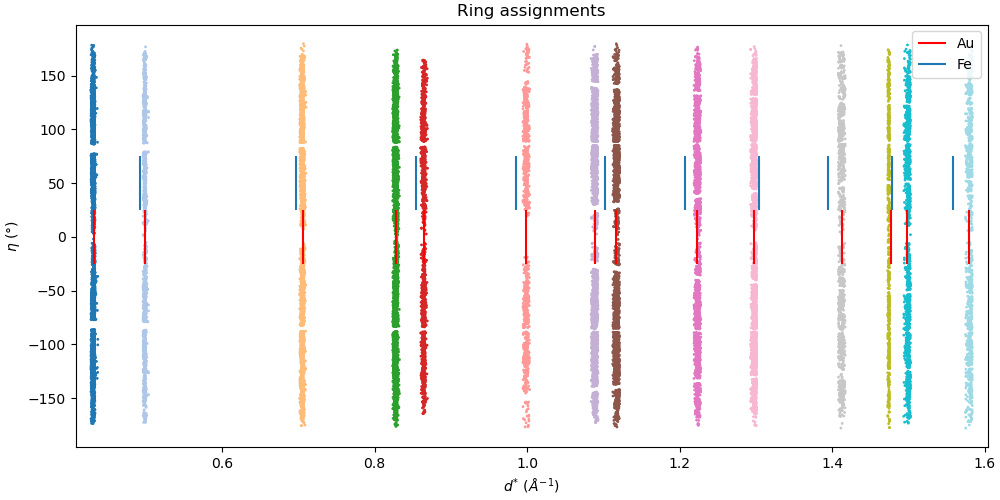

In [14]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(minor_phase_unitcell.ringds, -25, 25, color='red', label=minor_phase_unitcell.name)
for inc, major_phase_unitcell in enumerate(major_phase_unitcells):
    ax.vlines(major_phase_unitcell.ringds, -25+(50*(inc+1)), 25+(50*(inc+1)), color=plt.color_sequences['tab20'][inc], label=major_phase_unitcell.name)
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(minor_phase_unitcell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
ax.legend(loc='upper right')
plt.show()

In [15]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=minor_phase_unitcell,
                                dstol=minor_phase_cf_dstol,
                                forgen=rings_for_gen,
                                foridx=rings_for_scoring,
                                hkl_tols=hkl_tols_seq,
                                fracs=fracs,
                                cosine_tol=cosine_tol,
                                max_grains=max_grains
)
for ginc, g in enumerate(grains):
    g.gid = ginc
print(f'Found {len(grains)} grains!')

196 peaks expected
Trying these rings (counts, multiplicity, ring number): [(1160, 6, 5), (1892, 8, 4), (4493, 8, 0)]


0.9 0.01 0


0.9 0.02 6


0.9 0.03 21


0.9 0.04 39


0.9 0.05 61


0.7 0.01 61


0.7 0.02 63


0.7 0.03 63


0.7 0.04 73


0.7 0.05 90
Found 90 grains!


# Results

Median unit cell: [ 4.00084981  4.00344356  4.00773109 89.95185212 90.00868317 90.05561475]


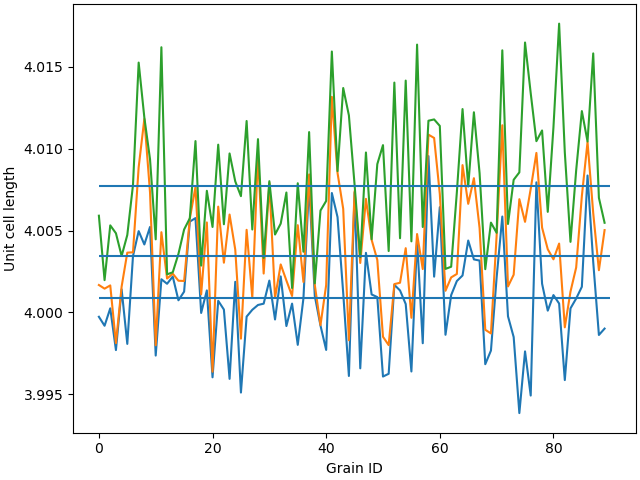

In [16]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel='Grain ID', ylabel='Unit cell length')
plt.show()

In [17]:
utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 90 grains


  0%|          | 0/90 [00:00<?, ?it/s]

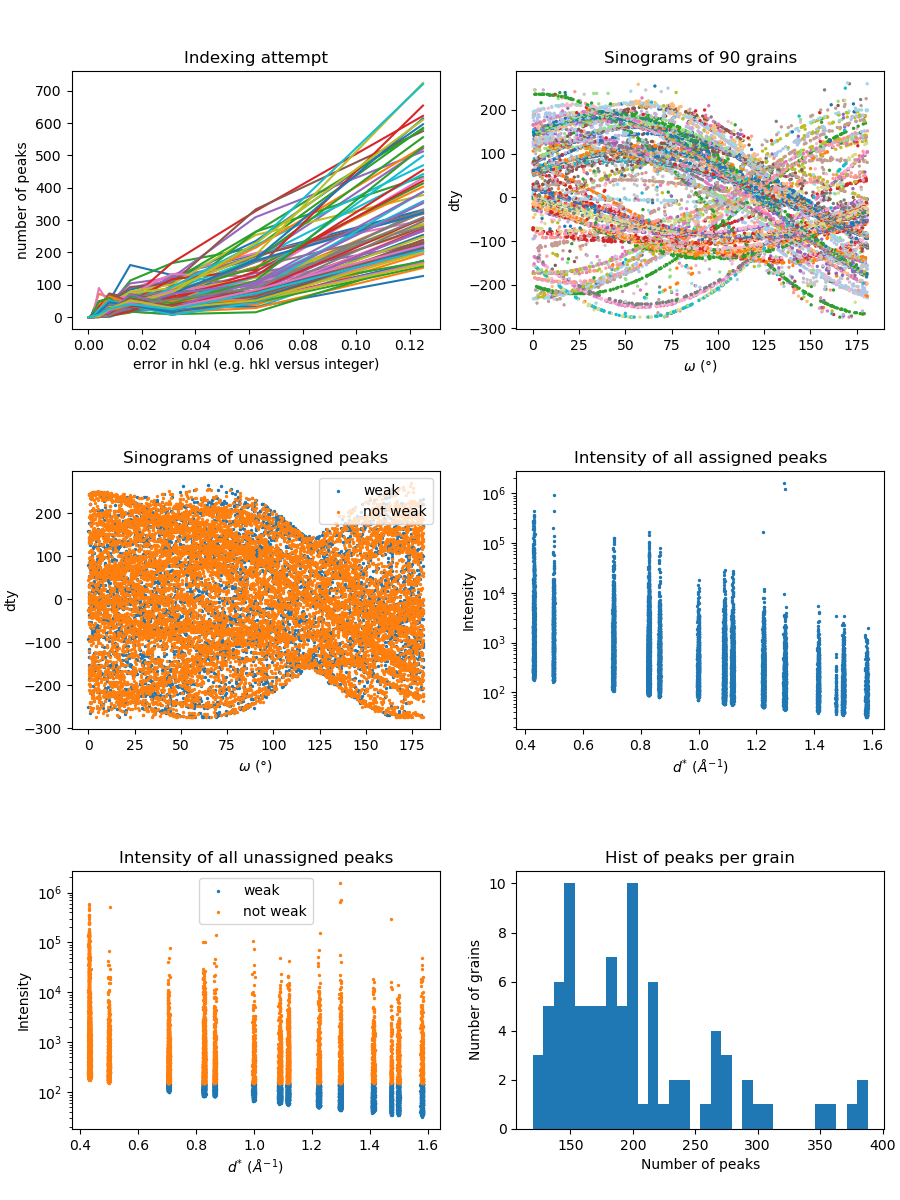

In [18]:
utils.plot_index_results(indexer, cf_strong, 'Indexing attempt')

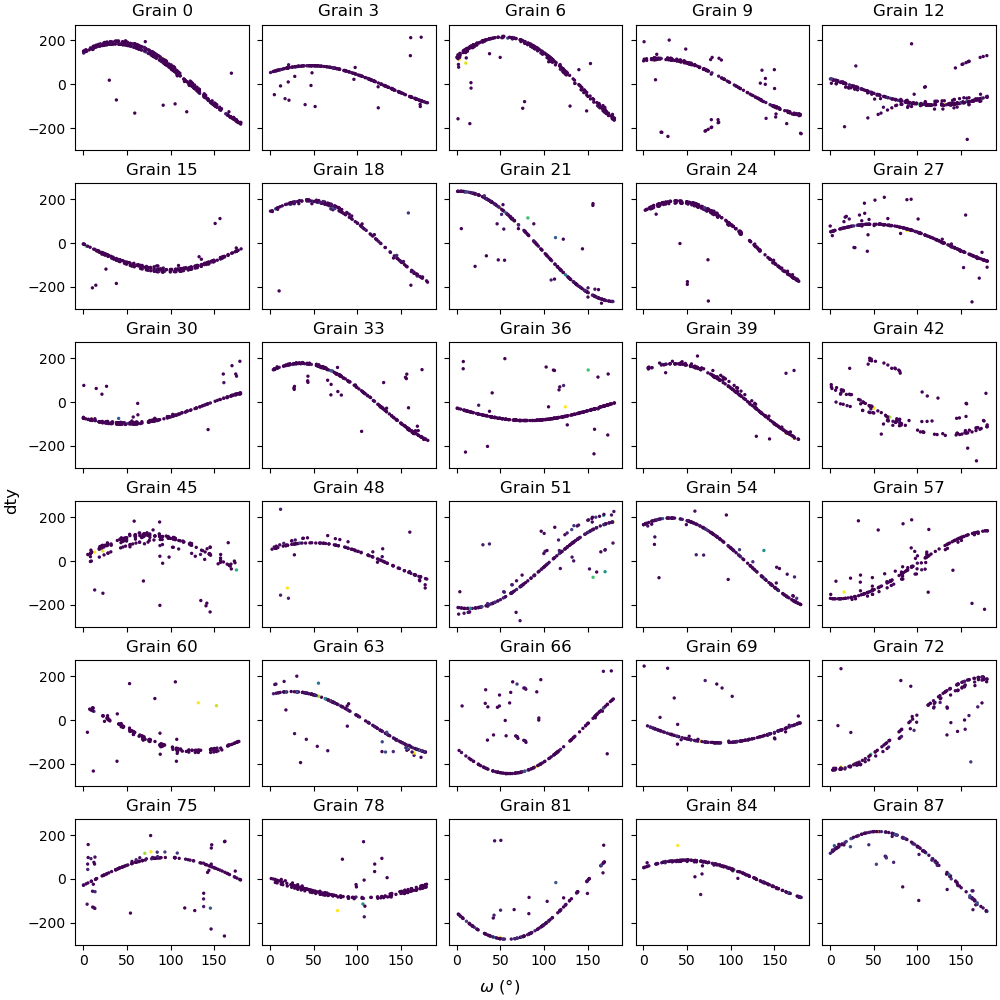

In [19]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Export data

In [20]:
ds.save_grains_to_disk(grains, phase_name=minor_phase_str)
ds.save()